In [20]:
#Azmain's base code

# Final Plots Displaying Calculated Equivalent Widths and Component Gaussians

import numpy as np
import matplotlib.pyplot as plt
#from specutils.io import read_fits
import pandas as pd
import glob
from lmfit import Model
from astropy.io import fits
from numpy import trapz
from astropy.time import Time
from PyAstronomy import pyasl
from getpass import getuser
from datetime import datetime

print('Working on '+getuser()+'.')

#directories:
# main dir:
gdir = r'C:\Users\ZY\Documents\github\233boy\Dr.-Yep-2024-summer-research\\'

# Goodman normalized spectra:
gndir = gdir + '\GoodmanNormBest\\'

#open normalized data, return w,f norm, f wfun (unnormalized, for sigmav),head,bcv:
def opfitsg(name):
    print('returns: w,f,fun,head,bc')
    # One target against one standard:
    #def fitvsinilite(name,stdname,rvcent0=0,vsinistart0=0,skipedge0=0,prin='n',plotyn='n',pltcc='n'): #returns the essentials.
    #For standards test, you don't account for each standard's uncert.
    #target:
    hdu=fits.open(gndir+'n_'+name+'.fits') #.fits data
    dat=hdu[0].data
    head=hdu[0].header
    hdu.close()
    bc=bcvg(head) #barycentric correction
    w,f=dat #total spectrum
    #unnorm for sigmav
    wfunfile=head['WFUNFILE']
    hdu=fits.open(gdir+wfunfile) #.fits data
    fun=hdu[0].data[1] #unnorm spectrum
    hdu.close()
    return w,f,fun,head,bc

#Ultimate opendat:
def opendatt(dir,filename,spl=''): #dir,'filename'. For opening a data file. Can then send through roundtable.
    f=open(dir+filename,'r')
    dat=f.readlines()
    f.close()
    if spl=='':
        labels=dat[0][0:-1].split()
        dat2=[[a.strip('\n') for a in d.split()] for d in dat if d[0]!='#']
    else:
        labels=dat[0][0:-1].split(spl)
        dat2=[[a.strip('\n') for a in d.split(spl)] for d in dat if d[0]!='#']
    dat3=[['nan' if a.strip()=='' else a for a in d] for d in dat2]
    return [dat3,labels]

def opendat(dirr,filename,params,splitchar='',prin='y'): #Use as var,var,var...=opendat(dir,'filename',['keys']).
    if splitchar=='':
        dat,label=opendatt(dirr,filename)
    else:
        dat,label=opendatt(dirr,filename,splitchar)  #Get keys by first leaving ['keys'] blank: opendat(dirr,filename,[])
    if prin=='y':
        print(label)
    varrs=[]
    for i in range(len(params)):
        j=label.index(params[i])
        try:
            var=np.array([float(d[j]) for d in dat]) #works for float.
            varrs.append(var)
        except ValueError:
            var=[d[j].strip() for d in dat] #works for strings.
            varrs.append(var)
    if len(params)==1:
        varrs=varrs[0]
    return varrs

def writedat(dirr,filename,pars,label): #.dat auto included. pars as [name,ra,dec] etc.
    datp=[[str(a[i]) for a in pars] for i in range(len(pars[0]))]
    f=open(dirr+filename+'.dat','w')
    print('\t'.join(label),file=f)
    print(label)
    for d in datp:
        print('\t'.join(d),file=f)
    f.close()
    print('It is written: '+filename+'.dat')
    
#mini normalizer
def smooth(w,f,wc,fc,deg):
    #Fit polynomial to cut spectra.
    Ac = np.zeros((len(wc),2)) 
    Ac[:,0] = wc 
    Ac[:,1] = fc 

    xc = Ac[:,0] 
    yc = Ac[:,1] 
    zc = np.polyfit(xc,yc,deg)
    #print(zc)
    pc = np.poly1d(zc)
    
    D = np.zeros((len(w),2)) 
    D[:,0] = w
    D[:,1] = f
    x = D[:,0]
    y = D[:,1]
    return pc(x)
    
def sigmavg(dat,head,w,f,fn): #fits data, fits header, wavelength, unnormalized flux, normalized flux; Goodman
    #w,f=wf(dat,o)
    gain=float(head['GAIN'])
    RN=float(head['RDNOISE'])
#     if head['MODES'].split(',')[int(head['MODE'])].strip()=='fiber':
#         K=2.5
#     elif head['MODES'].split(',')[int(head['MODE'])].strip()=='slicer':
#         K=9.
    K=5 #pixels binned across spectral order. Here, it's...? No clue.
    SNR=np.array(f)*gain/np.sqrt(np.array(f)*gain+K*RN**2.)
    c=299792.458 #km/s
    dfdw=deriv(w,fn)
    Sigmav=1./np.sqrt(np.nansum((np.array(dfdw)*np.array(w)*np.array(SNR)/c)**2.))
    return Sigmav

#By chain rule: df/dv = df/dw * w/c. So can use df/dw derivative and multiply by w/c for deriv at each pixel.
def deriv(X,Y): #numerical
    #middle: 2 derivs on either side of pixel, then average
    x0=np.array(X[:-2])
    y0=np.array(Y[:-2])
    x1=np.array(X[1:-1])
    y1=np.array(Y[1:-1])
    x2=np.array(X[2:])
    y2=np.array(Y[2:])
    dydx_m=((y1-y0)/(x1-x0)+(y2-y1)/(x1-x0))/2.
    #print(len(dydx_m))
    #ends: just do 1 deriv
    dydx_b=(Y[1]-Y[0])/(X[1]-X[0])
    dydx_e=(Y[-1]-Y[-2])/(X[-1]-X[-2])
    #combine:
    dydx=[dydx_b,]+list(dydx_m)+[dydx_e,]
    #print(len(dydx))
    return dydx

#For weighting results:
#By chain rule: df/dv = df/dw * w/c. So can use df/dw derivative and multiply by w/c for deriv at each pixel.

#barycentric correction
def bcvg(head): #for Goodman
    #RA,Dec,expt,jd (jd of middle of exposure time)

    # Coordinates of SOAR telescope for Goodman
    longitude = -1.*(70.+44./60.+1.11/3600.) #degrees, E=+,W=-
    latitude = -30.-14./60.-16.41/3600. #degrees
    altitude = 2713. #meters
    
    expt=head['EXPTIME'] #exposure time
    #print(expt,type(expt),type(Time(head['DATE-OBS']).jd))
    JD=Time(head['DATE-OBS']).jd+expt/2./60./24. #Julian day of middle of exposure, UT
    # Coordinates in degrees (J2000) for pyas1
    RA=[float(d)*15. for d in head['RA'].split(':')] #RA, degrees
    DEC=[float(d) for d in head['DEC'].split(':')] #Dec
    if '-' in head['DEC']:
        sign=-1.
    else:
        sign=1.
    ra2000 = RA[0]+RA[1]/60.+RA[2]/3600. #RA
    dec2000 = sign*(abs(DEC[0])+DEC[1]/60.+DEC[2]/3600.) #Dec

    # Barycentric velocity correction
    cor = pyasl.helcorr(longitude, latitude, altitude,ra2000, dec2000, JD)[0]
    return cor

def gaussian(x, amp, cen, wid): # Gaussian model
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return ((1 * amp) / (np.sqrt(2*np.pi) * wid)) * np.exp(-(x-cen)**2 / (2*wid**2)) 
gmodel = Model(gaussian)

#new sval 2024 (allow IV), let's try only up to K7, rest go to "10" to change class. K7 goes to "8."
def sval(ss): #'spt'
    def vs(s): #v from s, for single value
        if s=='nan':
            v= np.float('nan')
            return np.float('nan')
        else:
            val=60-['O','B','A','F','G','K','M','L','T','Y'].index(s[0])*10+(10-float(s[1:].strip('V').strip('I')))
        if s[0] in ['M','L','T','Y']: #M gets set back because of K; K7 should be right next to M0
            val+=2
        if 'III' in s:
            v= val-100.
        elif 'I' in s and 'III' not in s and 'V' not in s:
            v= val-200.
        else:
            v= val
        return v
    if type(ss)==str:
        final=vs(ss)
    if type(ss)==list or type(ss)==type(np.array([1])):
        final=[]
        for i in range(len(ss)):
            s=ss[i]
            v=vs(s)
            final.append(v)
    return final

def sptfromsval(s): #'spt'
    obafgkm=['O','B','A','F','G','K','M']
    if s<=12:
        s-=2 #handle the Ms
    if s>=0:
        lum='V'
        S=int(s/10.)
    elif s<0 and s>=-100:
        lum='III'
        S=int((s+100.)/10.)
    elif s<-100:
        lum='I'
        S=int((s+200.)/10.)
    else:
        print('Error with luminosity class.')
    clas=str(round(10-(s-float(10*S)),1)).replace('.0','')
    if round(10-(s-float(10*S)),1)==10:
        clas='0'
        S-=1
    oba=obafgkm[6-S]
    return oba+clas+lum

#retrieve rv,vsini,bcv from LogCruncher standards summary file
def refv(stdname):
    name,vsini,vsinierr,rv,rverr=opendat(cdir,'standards/standards_metadata.dat',['#name','vsini', 'vsinierr', 'rv', 'rverr'],splitchar='\t',prin='n')
    #bname,barycorr=opendat2(cdir,'standards/CHIRON_standards_bestobs.dat',['name','barycorr'])
    i=name.index(stdname)
    #j=bname.index(stdname)
    return vsini[i],vsinierr[i],rv[i],rverr[i]

def refspt(stdname):
    name,spt=opendat(cdir,'standards/standards_metadata.dat',['#name','spt'],splitchar='\t',prin='n')
    i=name.index(stdname)
    return spt[i]

# namervs,rvs,rverrs,cgrvs,vsinis=opendat2(ddir,'CG_rvs.dat',['#name','rv','rverr','CG','vsini'])
# namespts,spts=opendat2(cdir,'CGs/CGs_SpTGuess.dat',['#name','SpTGuess'])
# CGt,t=opendat2(ddir,'CG_properties.dat',['#CG','Myr'])

Working on ZY.


In [21]:
#Ha stuff

WA270=5.90795878101 #6.126670027 #270 km/s width from White and Basri 2003

c = 299792.458    # speed of light in km/s
center_ha = 6562.81 # central wavelength of H alpha at rest in air
r=((center_ha-WA270)/center_ha)**2.0
print(c*(1.0-r)/(1.0+r))

def Width(x,h,hh): #wavelength, central Ha, particular Ha (center, plus, or minus)
    left=np.interp(0.1*np.max(h),hh[:np.argmax(hh)],x[:np.argmax(hh)])
    right=np.interp(0.1*np.max(h),hh[np.argmax(hh):][::-1],x[np.argmax(hh):][::-1])
    print(left,right)
    
    WA=right-left
    r=((center_ha-WA)/center_ha)**2.0
    Wkms=c*(1.0-r)/(1.0+r)
    
    return WA,Wkms

def Width20(x,f,tweak,pltt='n',offset=0): #wavelength, flux
    left=np.interp(1.+0.1*(np.max(f-1.)+tweak),f[:np.argmax(f)],x[:np.argmax(f)])
    right=np.interp(1.+0.1*(np.max(f-1.)+tweak),f[np.argmax(f):][::-1],x[np.argmax(f):][::-1])
    print(left,right)
    
    WA=right-left
    r=((center_ha-WA)/center_ha)**2.0
    Wkms=c*(1.0-r)/(1.0+r)
    
    if pltt=='y':
        plt.plot([left,right],[1.+0.1*(np.max(f-1.)+tweak)+offset,1.+0.1*(np.max(f-1.)+tweak)+offset],marker='o',color='lime')
        plt.text(6500,offset+1.+1.2,'10% W = '+str(int(Wkms))+' km/s',fontsize=12)
    
    return WA,Wkms

def Width2(x,f,ferr,offset=0):
    WA,Wkms=Width20(x,f,0.,pltt='y',offset=offset)
    WAp,Wkmsp=Width20(x,f,ferr)
    WAm,Wkmsm=Width20(x,f,-1.*ferr)
    
    WAerr=np.mean([abs(WAp-WA),abs(WA-WAm)])
    Wkmserr=np.mean([abs(Wkmsp-Wkms),abs(Wkms-Wkmsm)])
    
    return WA,WAerr,Wkms,Wkmserr

c = 299792.458    # speed of light in km/s
center_ha = 6562.81 # central wavelength of H alpha at rest in air
#     center_li2 = 6707.9145 # central wavelength of right-most lithium line of Li7 I doublet at rest in air
#     center_fe = 6707.4308 # central wavelength of iron line blended with lithium doublet at rest in air
#delta_v = bc  # wavelength shift due to Earth's motion in km/s

def cen_ha(v,bc):
    return center_ha * ((c + v - bc) / c)

def halpha(x,amplitude_halpha,width,radial_velocity,bc):
        return (((-1 * amplitude_halpha) / (np.sqrt(2*np.pi) * width)) * np.exp(-(x-cen_ha(radial_velocity,bc))**2 / (2*width**2))) #+ (((-1 * amplitude_halpha) / (np.sqrt(2*np.pi) * width)) * np.exp(-(x-cen_ha(radial_velocity))**2 / (2*width**2))) + 1.0

namervs,rvs,rverrs,vsinis,vsinierrs=opendat(gdir,'GoodmanRVs.dat',['#name','rv','rverr','vsini','vsinierr'])    
namespts,spts=opendat(gdir,'GoodmanSpecTypes.dat',['#name','SpT'])

#/!\ Fix EW error handling: Use Azmain's flux thingy and pixel scale whatever. Then do "fake" thing with min max diff from uncert in wavelegth of continuum.
#You can allow fit, or you can go manual and choose left and right. If you go manual, you have to use left, right, and err. Overrides ha and wid.
def Ha(name,ha=0.01,wid=0.1,axx='n',offset=0,fat=1.,test='n',left='n',right='n',err='n',getem='n',empadleft=0.,empadright=0.,fwpadleftl=0,fwpadleftr=0,fwpadrightl=0,fwpadrightr=0,plotEWyn='y'): #for name in NAMES: #dat,rv in zip(data,Table): #fat is flux-at, should be normalized to 1., but if it's not there, put where it is.
    #offset=0.6*offset
    #target:
    
    w,f,fun,head,bc=opfitsg(name)
    rv,rverr,vsini=rvs[namervs.index(name)],rverrs[namervs.index(name)],vsinis[namervs.index(name)]
    spt=spts[namespts.index(name)]
    print('check for nans:',rv,rverr,vsini,spt)
    if np.isnan(rv):
        rv,rverr=0.,0.
    
    f0=fun
#     q=200
#     print('wavelength/pixel at',w[q],'A:',w[q]-w[q-1])
    
#     P=25 #25 hopefully keeps just envelope.
#     if 'K' in spt or 'M' in spt: #these have more absorption, raise P
#         P=30
    
#     p=f0[:100]>np.percentile(f0[:100],P)
#     env=smooth(w,f0,w[:100][p],f0[:100][p],1)
#     f=f0/env
    
    P=25 #25 hopefully keeps just envelope.
    if 'K' in spt or 'M' in spt: #these have more absorption, raise P
        P=30
    
    l1,l2=2500,2900
    r1,r2=3100,3500
    
    wnotha=np.array(list(w)[l1:l2]+list(w)[r1:r2])
    fnotha=np.array(list(f0)[l1:l2]+list(f0)[r1:r2])
    p=(fnotha>np.percentile(fnotha,P))*(fnotha<np.percentile(fnotha,95))
    env=smooth(w,f0,wnotha[p],fnotha[p],1)
    f=f0/env
    
    window=100
    iHa=(w>center_ha-window)*(w<center_ha+window)

    # Fit a gaussian to the spectral region of interest:
    wHa = w[iHa]
    fHa = f[iHa]

    x=np.linspace(np.min(wHa),np.max(wHa),1*len(wHa))
    y=np.interp(x,wHa,fHa)

    if left=='n': # determine width using fit.
        if wid==0.1 and vsini>100: #these have wider Halpha, widen window
            wid=3.

        def single_gaussian(x, v, amp_ha, wid):
            return (((-1 * amp_ha) / (np.sqrt(2*np.pi) * wid)) * np.exp(-(x-cen_ha(v,bc))**2 / (2*wid**2))) + 1.0

        gmodel = Model(single_gaussian)
        gmodel.set_param_hint('amp_ha') #, min=0) #can be abs or em
    #     gmodel.set_param_hint('amp_fe', min=0)
    #     gmodel.set_param_hint('wid', min=0)
        result = gmodel.fit(y, x=x, v=rv, amp_ha=ha, wid=wid, nan_policy='propagate')

        h = result.best_values
        #print(h)
    #     hp = result.best_fit-result.eval_uncertainty()
    #     hm = result.best_fit+result.eval_uncertainty()

        if "Warning: uncertainties could not be estimated" in result.fit_report():
            amp,amperr=[np.float('nan')]*3,[np.float('nan')]*3
        else:
            report=[l[l.index(':')+1:l.index('(')] for l in result.fit_report().split('\n') if 'amp_ha:' in l or 'wid:' in l]
            #print(report)
            amp=[float(r.split('+/-')[0].strip()) for r in report]
            amperr=[float(r.split('+/-')[1].strip()) for r in report]
            print('Ha         \tWidth')
            print(amp)
            print(amperr)

        Hamp,Hamperr=amp[0],amperr[0]
        H,Hp,Hm=Hamp,Hamp+Hamperr,Hamp-Hamperr

        #def www(h):
        amplitude_halpha = h['amp_ha']
        radial_velocity = h['v']
    #     amplitude_iron = h['amp_fe']
        width = h['wid']

    #     print('L =',L,'amp_li =',amplitude_lithium)
    #     print(L==amplitude_lithium)

    #     def iron(x,amplitude_iron):
    #         return (((-1 * amplitude_iron) / (np.sqrt(2*np.pi) * width)) * np.exp(-(x-cen_fe(radial_velocity))**2 / (2*width**2))) + 1.0

        #Widths from fits:
        #W_combined = trapz(1. - result.best_fit, x)
    #     W_ha = abs(trapz(halpha(x,amplitude_halpha,width,radial_velocity,bc), x)) #trapz(1. - halpha(x,amplitude_halpha), x)
    #     W_hap = abs(trapz(halpha(x,Hp,width,radial_velocity,bc), x))
    #     W_ham = abs(trapz(halpha(x,Hm,width,radial_velocity,bc), x))
    #     W_haerr=abs(np.mean([W_hap-W_ha,W_ha-W_ham]))

        print('Halpha max:',np.max(H))
        if axx=='n':
            fig = plt.figure(figsize=(10,6))
            ax = fig.add_subplot(111)
            #ax.plot(x, y,'b-', label='original')
            #plt.plot(x,[1+offset]*len(x),color='gray',lw=1,ls='--') #normalized
            ax.set_xlabel('Wavelength (Angstrom)')
            ax.set_ylabel('Flux (arb. units)')
        #         lgd = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
        #         ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            #ax.legend(loc='best')
            #ax.set_ylim(top=1.15)
            #ax.set_ylim(bottom=0.70)
            ax.set_title(name)
        else:
            plt.text(6500,1.05+offset,str(axx)+': '+name)
            plt.plot([6562.81,6562.81],[0,len(cgs)],lw=1,ls='--',color='gray')
            plt.yticks(np.arange(0, len(cgs), 0.5))

        plt.plot([cen_ha(radial_velocity,bc)-WA270/2.,cen_ha(radial_velocity,bc)-WA270/2.],[1+offset,np.max(result.best_fit)+offset],color='orchid',ls='--')
        plt.plot([cen_ha(radial_velocity,bc)+WA270/2.,cen_ha(radial_velocity,bc)+WA270/2.],[1+offset,np.max(result.best_fit)+offset],color='orchid',ls='--')
        plt.plot(w[l1:r2],f[l1:r2]+offset,'b-', label='original')
        plt.plot([w[l1],w[r2]],[1+offset,1+offset],color='gray',lw=1,ls='--') #normalized
        plt.xlim(w[l1],w[r2])
        plt.plot(x, result.best_fit+offset, 'r-', label='H alpha')

        #ax.plot(x, halpha(x,amplitude_halpha), 'k--', label='H alpha')
    #        
    #         plt.set_xlabel('Wavelength (Angstrom)')
    #         plt.set_ylabel('Flux (arb. units)')
    #     #         lgd = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    #     #         ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #         plt.legend(loc='best')
    #         plt.set_ylim(top=1.15)
    #         #ax.set_ylim(bottom=0.70)
    #         plt.text(0.5, 0.85, 'v:                      ' + str(radial_velocity) + '\namp_li:          ' + str(amplitude_lithium) + '\namp_fe:       ' + str(amplitude_iron) + '\nwid:                  ' + str(width) + '\nW_combined: ' + str(W_combined) + '\nW_li:                 ' + str(W_li) + '\nW_fe:              ' + str(W_fe) , fontsize=8, ha='center', va='center', transform=ax.transAxes)
    #         plt.set_title(dat)

        #plt.savefig(save_newfit + file.replace('.fits','') + '_fit.png')
    #         fig.savefig(save_newfit + dat + '_fit.png', bbox_extra_artists=(lgd,title,), bbox_inches='tight')
    #         fig1 = plt.gcf()
    #         fig1.set_size_inches(10,10)
        #plt.close()
    #     print(W_fe,W_fep,W_fem)
    #     print('EW Fe =',W_fe,'+/-',W_feerr,'A')
        #return result,x,y,W_li,W_lierr,W_fe,W_feerr

        hh,hp,hm=halpha(x,amplitude_halpha,width,radial_velocity,bc),halpha(x,Hp,width,radial_velocity,bc),halpha(x,Hm,width,radial_velocity,bc)

        #Widths from the spectrum as-is:
        if np.sum(hh)<=0:
            keep=hh<-0.01 #*np.min(hh)
        elif np.sum(hh)>0:
            keep=hh>0.01 #*np.max(hh)
        else:
            return np.float('nan'),np.float('nan'),np.float('nan'),np.float('nan'),'nan'
        keepp=(w>x[keep][0])*(w<x[keep][-1])
        W_ha = trapz(1.-f[keepp], w[keepp]) #trapz(1. - halpha(x,amplitude_halpha), x)
    #     W_hap = abs(trapz(halpha(x,Hp,width,radial_velocity,bc), x))
    #     W_ham = abs(trapz(halpha(x,Hm,width,radial_velocity,bc), x))
        fnotha2=np.array(list(f)[l1:l2]+list(f)[r1:r2])
        p2=(fnotha2>np.percentile(fnotha2,P))*(fnotha2<np.percentile(fnotha2,95))
        ferr=np.std(fnotha2[p2])
        
        #Uncert of EW:
        #from Azmain's paper, Eq. 1
        wavelengthres=center_ha/25000. #resolution of fiber mode
        pix=0.097 # #0.097 from checking wavelength spacing between one pixel and the next at w = 6563 A.
        #find half max:
        if amplitude_halpha<0:
            maxx=np.max(f[keepp])-1.
            halfmax=maxx/2.+1.-ferr
            leftt=np.interp(halfmax,f[keepp][:np.argmax(f[keepp])],w[keepp][:np.argmax(f[keepp])])
            rightt=np.interp(halfmax,f[keepp][np.argmax(f[keepp]):][::-1],w[keepp][np.argmax(f[keepp]):][::-1])
        else:
            maxx=np.min(f[keepp])-1.
            halfmax=maxx/2.+1.+ferr
            leftt=np.interp(1.-halfmax,1.-f[keepp][:np.argmin(f[keepp])],w[keepp][:np.argmin(f[keepp])])
            rightt=np.interp(1.-halfmax,1.-f[keepp][np.argmin(f[keepp]):][::-1],w[keepp][np.argmin(f[keepp]):][::-1])
        if plotEWyn=='y':
            plt.plot([leftt,rightt],[halfmax,halfmax],color='deepskyblue',marker='o')
        fwhm=rightt-leftt #THE width from Gaussian is based on +/- 1 sigma. FWHM is something else.
        print('FWHM:',fwhm,'A')
        gain=float(head['GAIN'])
        RN=float(head['RDNOISE'])
    #     if head['MODES'].split(',')[int(head['MODE'])].strip()=='fiber':
    #         K=2.5
    #     elif head['MODES'].split(',')[int(head['MODE'])].strip()=='slicer':
    #         K=9.
        K=5 #pixels binned across spectral order. Here, it's...? No clue.
        fraw=fun #wf(dat,o)[1] #raw flux for SNR
        SNR=np.array(fraw)*gain/np.sqrt(np.array(fraw)*gain+K*RN**2.)
        snr=sum(SNR[keepp])/len(SNR[keepp]) #snr/pixel
        EWerr=1.5*np.sqrt(fwhm*pix)/snr
        
        W_haerr=EWerr #np.sqrt(ferr**2.*len(x[keep])+wavelengthres**2.) #add flux uncertainty in quadrature
        plt.plot(w[keepp],f[keepp]+offset,lw=2,color='magenta')
        plt.text(6500,1+offset+0.15, 'v:                      ' + str(round(radial_velocity,2)) + '\namp_ha:          ' + str(round(amplitude_halpha,2)) + '\nW_ha:                 ' + str(round(W_ha,2)), fontsize=12)
        #print(W_ha,W_hap,W_ham)
        print('EW Ha =',W_ha,'+/-',W_haerr,'A')

        if test=='y':
            return W_ha,W_haerr,x,halpha(x,amplitude_halpha,width,radial_velocity,bc),halpha(x,Hp,width,radial_velocity,bc),halpha(x,Hm,width,radial_velocity,bc) #,W_fe,W_feerr
    
    else: #manual! (triggered by left!='n', that is, left=float)
        print('/!\ Manual measure.')
        radial_velocity=rv
        if right=='n' or err=='n':
            print('To use manual mode, you must specify left, right, and err. Variables ha and wid are irrelevant and overriden.')
        
        if axx=='n':
            fig = plt.figure(figsize=(10,6))
            ax = fig.add_subplot(111)
            #ax.plot(x, y,'b-', label='original')
            #plt.plot(x,[1+offset]*len(x),color='gray',lw=1,ls='--') #normalized
            ax.set_xlabel('Wavelength (Angstrom)')
            ax.set_ylabel('Flux (arb. units)')
        #         lgd = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
        #         ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            #ax.legend(loc='best')
            #ax.set_ylim(top=1.15)
            #ax.set_ylim(bottom=0.70)
            ax.set_title(name)
        else:
            plt.text(6500,1.05+offset,str(axx)+': '+name)
            plt.plot([6562.81,6562.81],[0,len(cgs)],lw=1,ls='--',color='gray')
            plt.yticks(np.arange(0, len(cgs), 0.5))

        plt.plot([cen_ha(radial_velocity,bc)-WA270/2.,cen_ha(radial_velocity,bc)-WA270/2.],[1+offset,np.max(f[0:300])+offset],color='orchid',ls='--')
        plt.plot([cen_ha(radial_velocity,bc)+WA270/2.,cen_ha(radial_velocity,bc)+WA270/2.],[1+offset,np.max(f[0:300])+offset],color='orchid',ls='--')
        plt.plot(w[l1:r2],f[l1:r2]+offset,'b-', label='original')
        plt.plot([w[l1],w[r2]],[1+offset,1+offset],color='gray',lw=1,ls='--') #normalized
        plt.xlim(w[l1],w[r2])
#         plt.plot(x, result.best_fit+offset, 'r-', label='H alpha')
        
        keep=(x>left)*(x<right)
        keepp=(w>left)*(w<right)
        W_ha = trapz(1.-f[keepp], w[keepp]) #trapz(1. - halpha(x,amplitude_halpha), x)
        amplitude_halpha=0.
    #     W_hap = abs(trapz(halpha(x,Hp,width,radial_velocity,bc), x))
    #     W_ham = abs(trapz(halpha(x,Hm,width,radial_velocity,bc), x))
        fnotha2=np.array(list(f)[l1:l2]+list(f)[r1:r2])
        p2=(fnotha2>np.percentile(fnotha2,P))*(fnotha2<np.percentile(fnotha2,95))
        ferr=np.std(fnotha2[p2])
        
        #Uncert of EW:
        #from Azmain's paper, Eq. 1
        wavelengthres=center_ha/25000. #resolution of fiber mode
        pix=0.097 # #0.097 from checking wavelength spacing between one pixel and the next at w = 6563 A.
        #find half max:
        if W_ha<0:
            maxx=np.max(f[keepp])-1.
            halfmax=maxx/2.+1.-ferr
            keeppl=(w>w[keepp][0]+fwpadleftl)*(w<w[keepp][np.argmax(f[keepp])]-fwpadleftr)
            keeppr=(w>w[keepp][np.argmax(f[keepp])]+fwpadrightl)*(w<w[keepp][-1]-fwpadrightr)
            print(w[keeppl])
            plt.plot(w[keeppl],f[keeppl],color='red')
            leftt=np.interp(halfmax,f[keeppl],w[keeppl])
            rightt=np.interp(halfmax,f[keeppr][::-1],w[keeppr][::-1])
        else:
            maxx=np.min(f[keepp])-1.
            halfmax=maxx/2.+1.+ferr
            keeppl=(w>w[keepp][0]+fwpadleftl)*(w<w[keepp][np.argmin(f[keepp])]-fwpadleftr)
            keeppr=(w>w[keepp][np.argmin(f[keepp])]+fwpadrightl)*(w<w[keepp][-1]-fwpadrightr)
            print(w[keeppl])
            plt.plot(w[keeppl],f[keeppl],color='red')
            leftt=np.interp(halfmax,f[keeppl][::-1],w[keeppl][::-1])
            rightt=np.interp(halfmax,f[keeppr],w[keeppr])
        plt.plot([leftt,rightt],[halfmax,halfmax],color='deepskyblue',marker='o')
        fwhm=rightt-leftt #THE width from Gaussian is based on +/- 1 sigma. FWHM is something else.
        print('FWHM:',fwhm,'A')
        gain=float(head['GAIN'])
        RN=float(head['RDNOISE'])
    #     if head['MODES'].split(',')[int(head['MODE'])].strip()=='fiber':
    #         K=2.5
    #     elif head['MODES'].split(',')[int(head['MODE'])].strip()=='slicer':
    #         K=9.
        K=5 #pixels binned across spectral order. Here, it's...? No clue.
        fraw=fun #wf(dat,o)[1] #raw flux for SNR
        SNR=np.array(fraw)*gain/np.sqrt(np.array(fraw)*gain+K*RN**2.)
        snr=sum(SNR[keepp])/len(SNR[keepp]) #snr/pixel
        EWerr=1.5*np.sqrt(fwhm*pix)/snr
        
        keepmin=(w>left)*(w<left+err)+(w>right-err)*(w<right)
        keepmax=(w>left-err)*(w<left)+(w>right)*(w<right+err)
        errmin = trapz(1.-f[keepmin], w[keepmin])
        errmax = trapz(1.-f[keepmax], w[keepmax])
        errmean=np.mean([errmin,errmax])
        print('Err from eyeballing fit:',errmin,errmax,errmean)
        
        W_haerr=np.sqrt(EWerr**2.+err**2.) #add flux uncertainty in quadrature.
        plt.plot(w[keepp],f[keepp]+offset,lw=2,color='magenta')
        plt.plot([left,left],[np.min(f[keepp]+offset)-0.01,np.max(f[keepp]+offset)+0.01],color='gray')
        plt.plot([right,right],[np.min(f[keepp]+offset)-0.01,np.max(f[keepp]+offset)+0.01],color='gray')
        
        plt.plot([left-err,left-err],[0.95,1.05],color='m')
        plt.plot([left+err,left+err],[0.95,1.05],color='m')
        plt.plot([right-err,right-err],[0.95,1.05],color='m')
        plt.plot([right+err,right+err],[0.95,1.05],color='m')
        
        plt.text(6500,1+offset+0.15, 'v:                      ' + str(round(radial_velocity,2)) + '\namp_ha:          ' + 'n/a' + '\nW_ha:                 ' + str(round(W_ha,2)), fontsize=12)
        #print(W_ha,W_hap,W_ham)
        print('EW Ha =',W_ha,'+/-',W_haerr,'A')
        
        #for 10% width:
        keepp=(w>left+empadleft)*(w<right-empadright)
    
    if amplitude_halpha<0 or W_ha<0 or getem=='y': #emission
        WA,WAerr,Wkms,Wkmserr0=Width2(w[keepp],f[keepp],ferr,offset=offset)
#         WAerr=(WAp-WA+WA-WAm)/2.
#         Wkmserr=(Wkmsp-Wkms+Wkms-Wkmsm)/2.

        #Maybe add kms version of EW uncert? Not sure if it's right or not but seems closer.
#         rEW=((center_ha-W_haerr)/center_ha)**2.0
#         WkmsEW=c*(1.0-rEW)/(1.0+rEW)
        #How about resolution instead?
        rdl=((center_ha-wavelengthres)/center_ha)**2.0
        Wkmsdl=c*(1.0-rdl)/(1.0+rdl)
        #add in quadrature:
        Wkmserr=np.sqrt(Wkmserr0**2.+Wkmsdl**2.)

        print('Ha 10% width:')
        print(WA,'+/-',WAerr,'A')
        print(Wkms,'+/-',Wkmserr,'km/s')

        return W_ha,W_haerr,Wkms,Wkmserr,'e'
    else:
        return W_ha,W_haerr,np.float('nan'),np.float('nan'),'a'

270.00000000003
['#name', 'rv', 'rverr', 'vsini', 'vsinierr']
['#name', 'object', 'SpT', 'spt_func', 'norm', 'deg', 'peak', 'file', 'wfunfile', 'notes']


## Measure Ha Equivalent Width (A) and 10% Peak Width (km/s)

returns: w,f,fun,head,bc


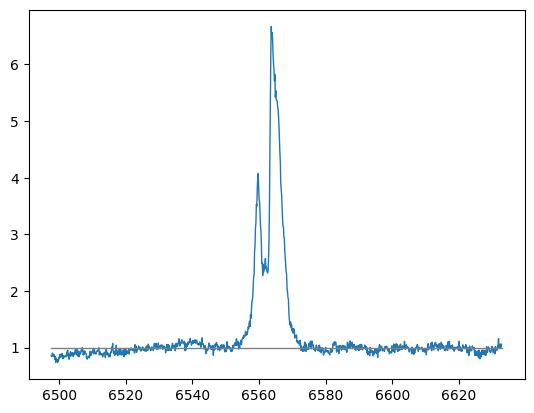

In [22]:
w,f,fun,head,bc=opfitsg('CG30_5')
b=2500
e=3500

plt.plot(w[b:e],f[b:e],lw=1)
plt.plot([w[b],w[e]],[1,1],color='gray',lw=1)

returns: w,f,fun,head,bc
check for nans: 21.849004202965034 1.7459793538010293 33.37302078819364 M2.5V
Ha         	Width
[-30.9159224, 2.98750292]
[0.40990616, 0.04573785]
Halpha max: -30.9159224
FWHM: 3.490462684438171 A
EW Ha = -31.95380587330679 +/- 0.01985216050904668 A
6557.4339441850325 6569.055609129789
6557.437314047024 6569.0499066092625
6557.43057432304 6569.061311650316
Ha 10% width:
11.621664944756958 +/- 0.009072382519207167 A
531.353546733597 +/- 11.999122574778827 km/s


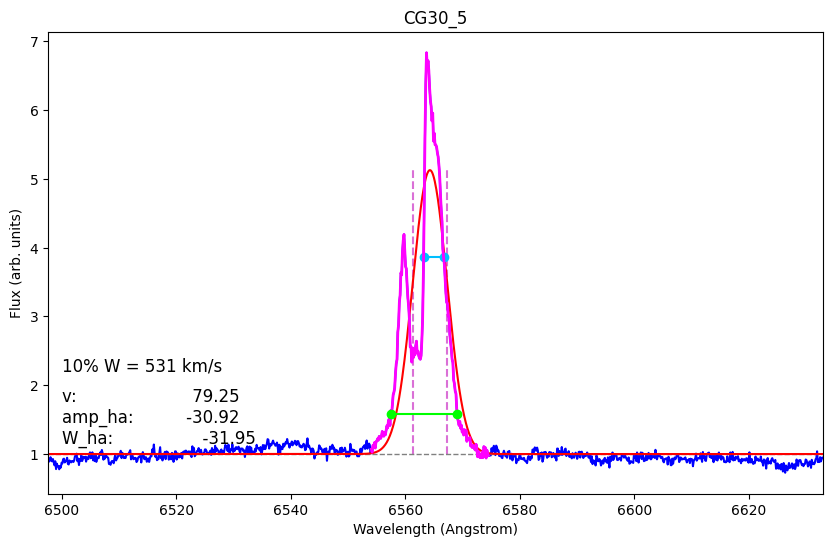

In [23]:
#Demo:
EWHa,EWHaerr,WHakms,WHakmserr,eora=Ha('CG30_5')